In [1]:
'''Clear out temporary variables and get a clean session'''
try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass

In [3]:
'''Open pickled file'''
with open('mib_final.pkl', 'rb') as f:
    df = pickle.load(f)

<AxesSubplot:>

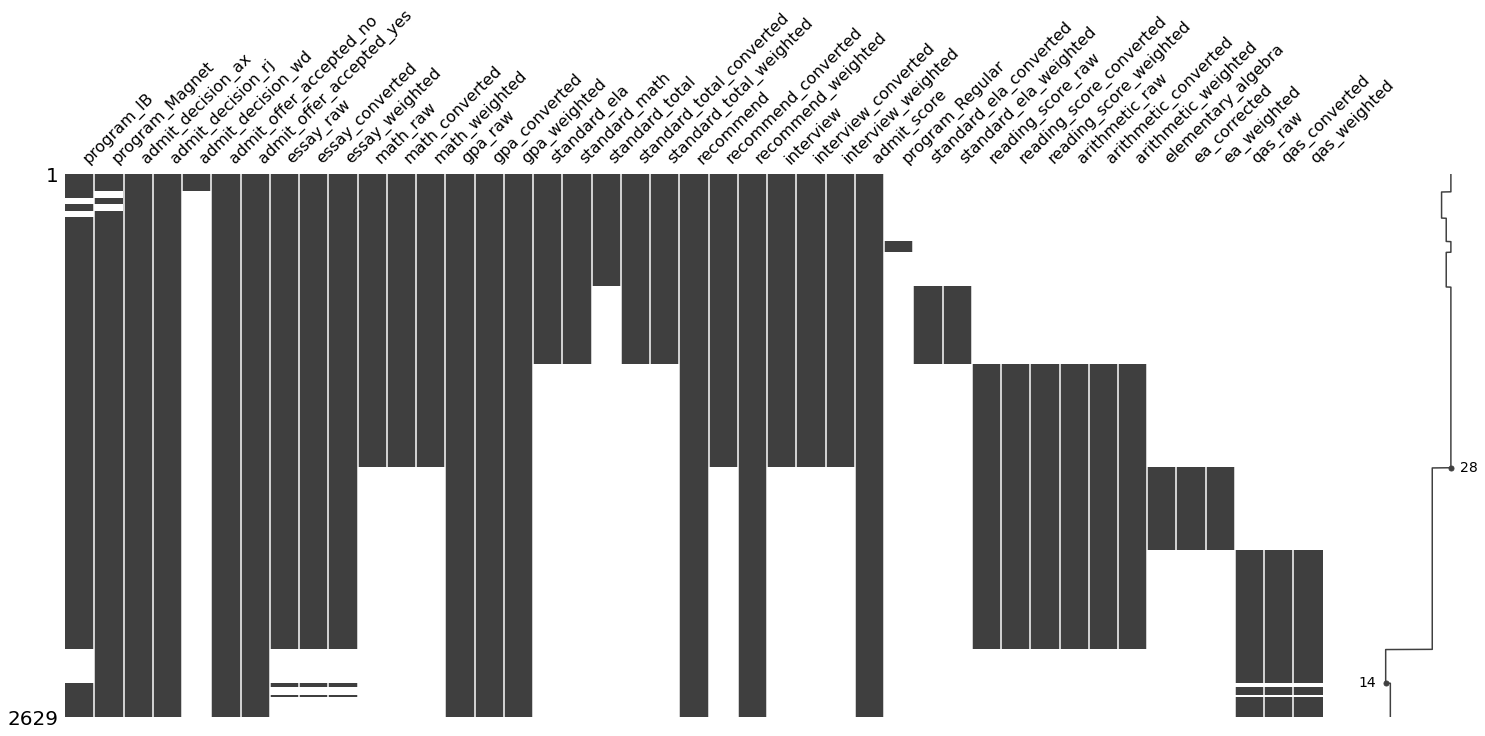

In [4]:
msno.matrix(df)

In [5]:
'''Combine data columns'''
df['math_raw'] = df['math_raw'].combine_first(df['arithmetic_raw'])
df['math_converted'] = df['math_converted'].combine_first(df['arithmetic_converted'])
df['math_weighted'] = df['math_weighted'].combine_first(df['arithmetic_weighted'])

df['standard_ela'] = df['standard_ela'].combine_first(df['reading_score_raw'])

<AxesSubplot:>

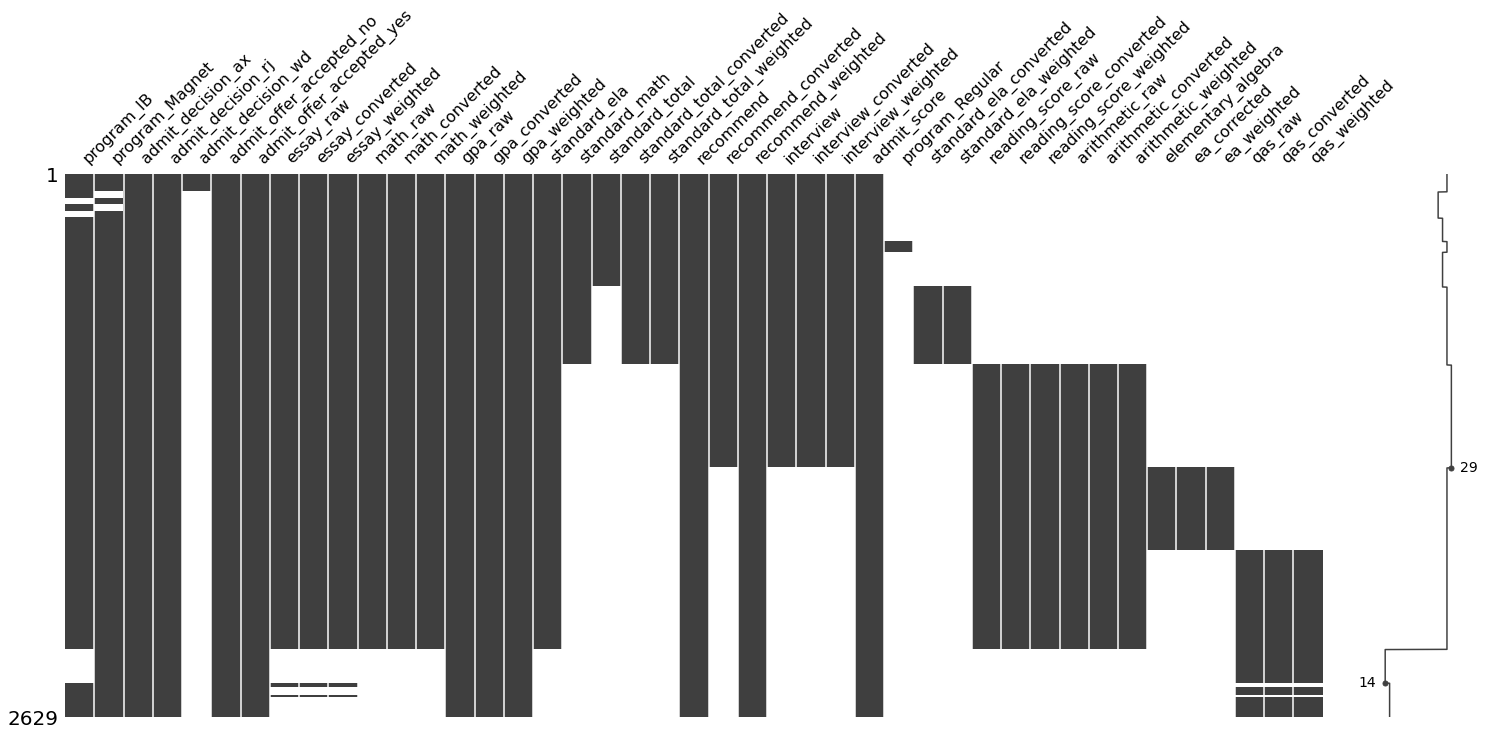

In [6]:
msno.matrix(df)

In [7]:
'''Further combine data columns'''
df['math_raw'] = df['math_raw'].combine_first(df['qas_raw'])
df['math_converted'] = df['math_converted'].combine_first(df['qas_converted'])
df['math_weighted'] = df['math_weighted'].combine_first(df['qas_weighted'])

<AxesSubplot:>

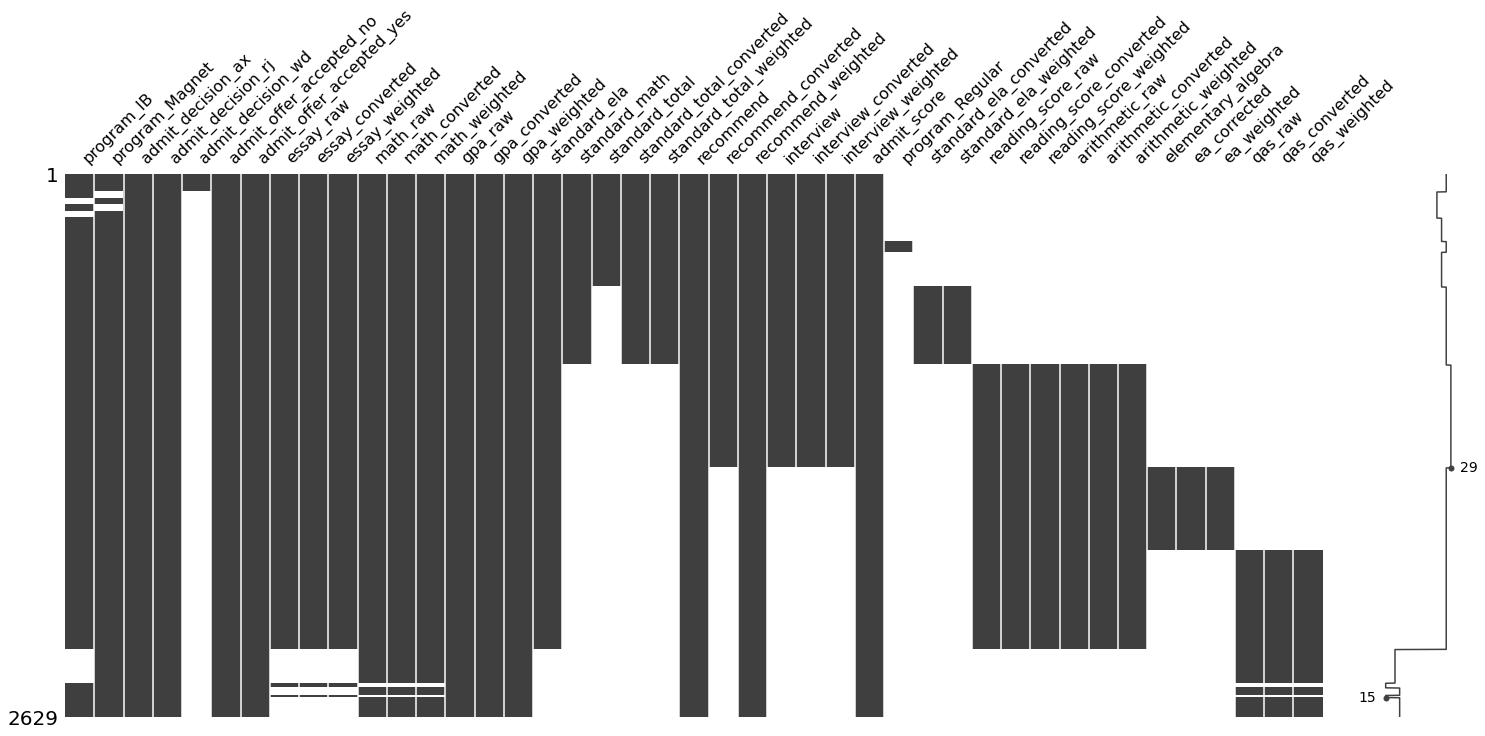

In [8]:
msno.matrix(df)

In [9]:
'''Drop duplicate and/or sparse columns'''
df.drop(['admit_decision_wd', 'program_Regular','standard_math', 'standard_total', 'standard_total_converted', 'standard_total_weighted',\
         'standard_ela_converted', 'standard_ela_weighted', 'reading_score_raw','reading_score_converted',\
         'reading_score_weighted', 'arithmetic_raw', 'arithmetic_converted', 'arithmetic_weighted', 'qas_raw', 'qas_converted',\
         'qas_weighted', 'elementary_algebra', 'ea_corrected', 'ea_weighted'], axis = 1, inplace=True)

In [10]:
'''Fill NaNs in program columns'''

df['program_IB'].replace(np.nan, 0, inplace = True)
df['program_Magnet'].replace(np.nan, 0, inplace = True)

In [11]:
'''Create column for program/acceptance status'''
conditions = [
    (df['program_IB'] == 0) & (df['admit_decision_ax'] == 0),
    (df['program_IB'] == 0) & (df['admit_decision_ax'] == 1),
    (df['program_IB'] == 1) & (df['admit_decision_ax'] == 0),
    (df['program_IB'] == 1) & (df['admit_decision_ax'] == 1)]

values = ['Magnet-Rejected', 'Magnet-Accepted', 'IB-Rejected', 'IB-Accepted']

df['program_admit'] = np.select(conditions, values)

<AxesSubplot:>

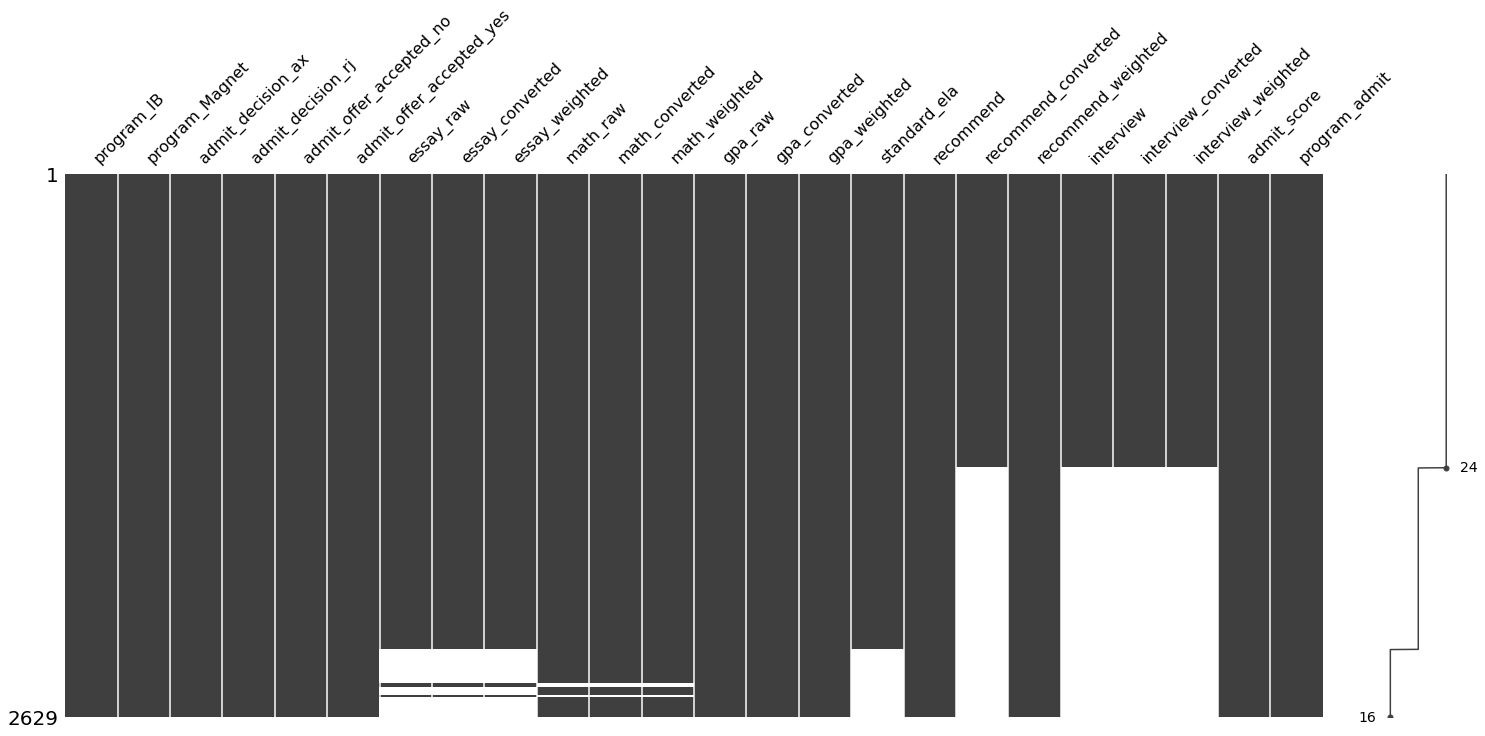

In [92]:
msno.matrix(df)

In [94]:
'''Pickle datafile'''
with open('mib_final_combine.pkl', 'wb') as f:
    pickle.dump(df, f)

In [72]:
'''Create separate dataframes for magnet and ib'''
ib_df = df.loc[df['program_IB'] == 1]
magnet_df = df.loc[df['program_Magnet'] == 1]

In [13]:
df.columns
plot_list = ['program_admit','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']

In [14]:
def qq_plot (df):
    for column in df.columns:
        print(column)
        sm.qqplot(df[column], line ='s', fit = True)

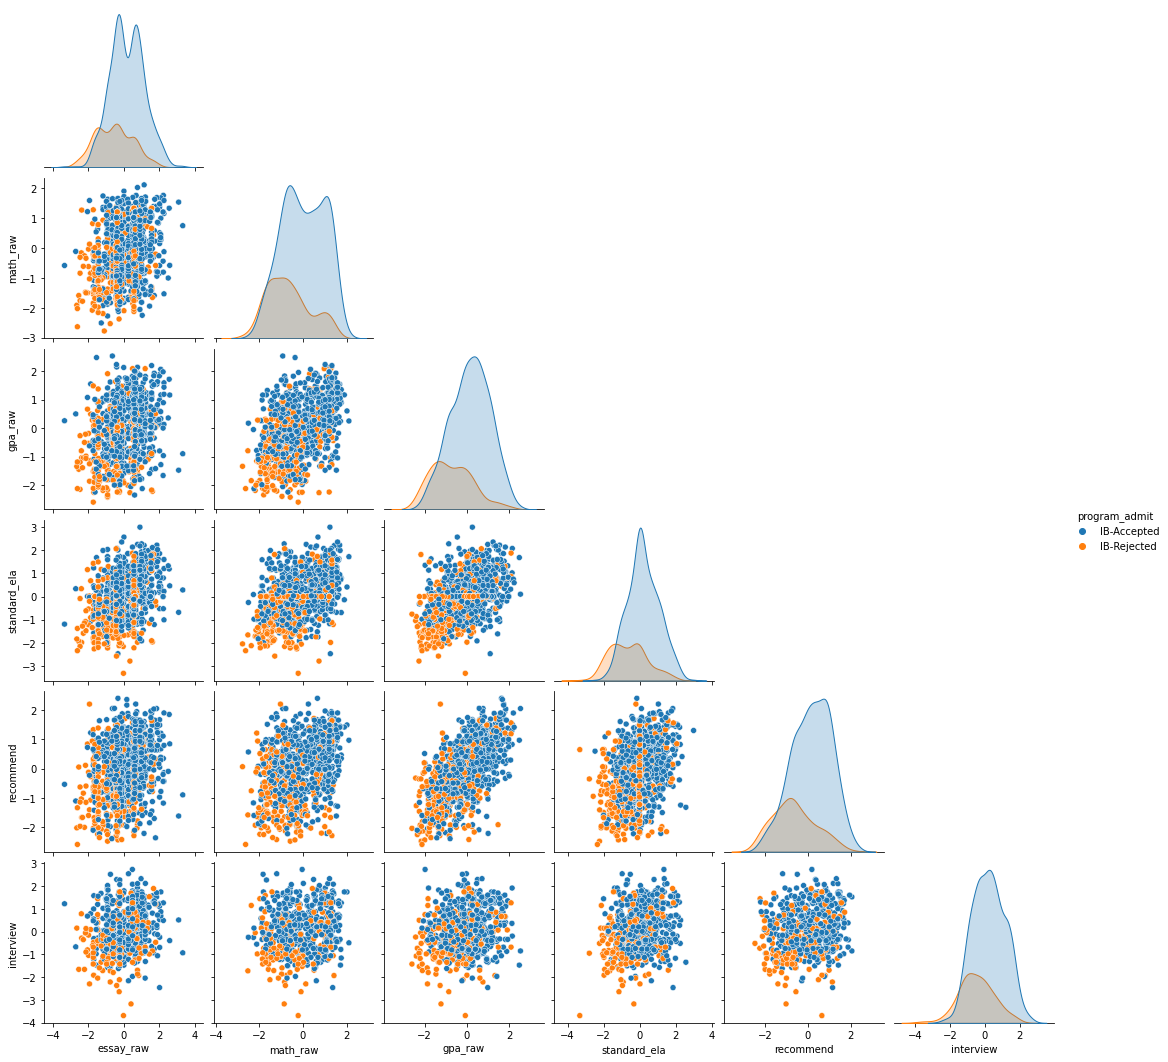

In [15]:
'''Create pariplots to show relationships between variables - IB'''
sns.pairplot(ib_df[plot_list], kind = 'scatter', hue = 'program_admit', corner = True)

<AxesSubplot:>

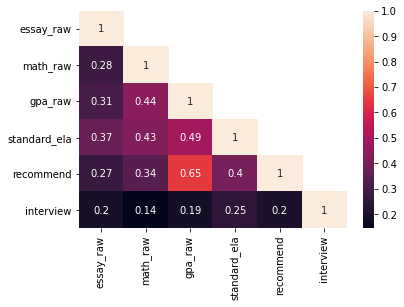

In [16]:
'''Correlation Heatmap - IB'''
df_corr_ib = ib_df[plot_list].corr()
matrix = pd.DataFrame(np.tril(df_corr_ib), columns = df_corr_ib.columns).replace(0, np.nan)
matrix.set_index(df_corr_ib.columns, drop = True, inplace = True)
sns.heatmap(matrix, annot=True)

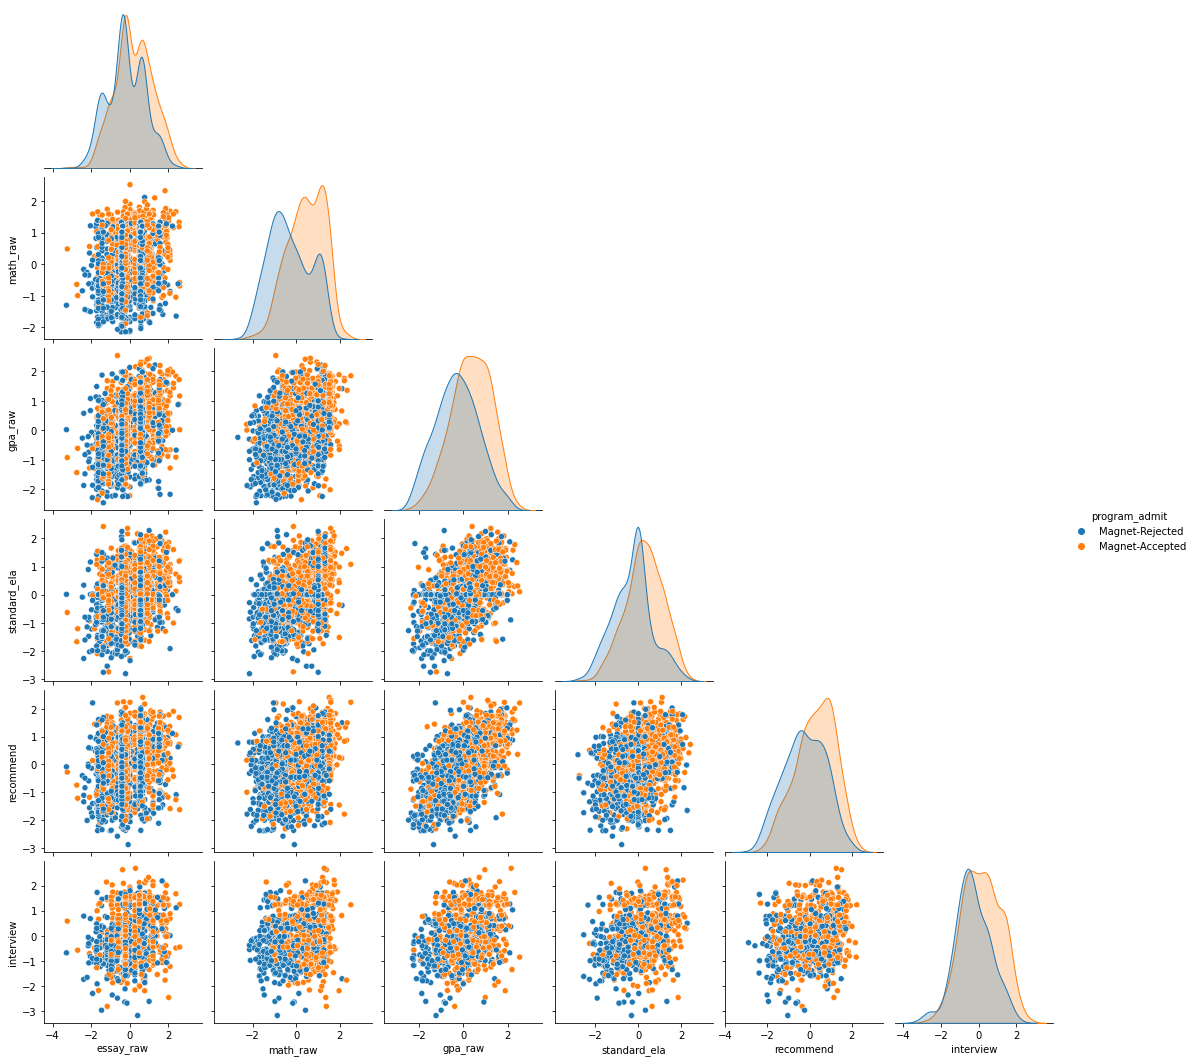

In [17]:
'''Create pariplots to show relationships between variables - Magnet'''
sns.pairplot(magnet_df[plot_list], kind = 'scatter', hue = 'program_admit', corner = True)

<AxesSubplot:>

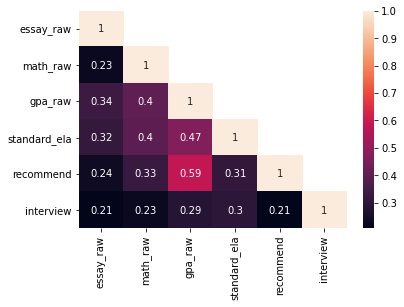

In [18]:
'''Correlation Heatmap - Magnet'''
df_corr_magnet = magnet_df[plot_list].corr()
matrix = pd.DataFrame(np.tril(df_corr_magnet), columns = df_corr_magnet.columns).replace(0, np.nan)
matrix.set_index(df_corr_magnet.columns, drop = True, inplace = True)
sns.heatmap(matrix, annot=True)

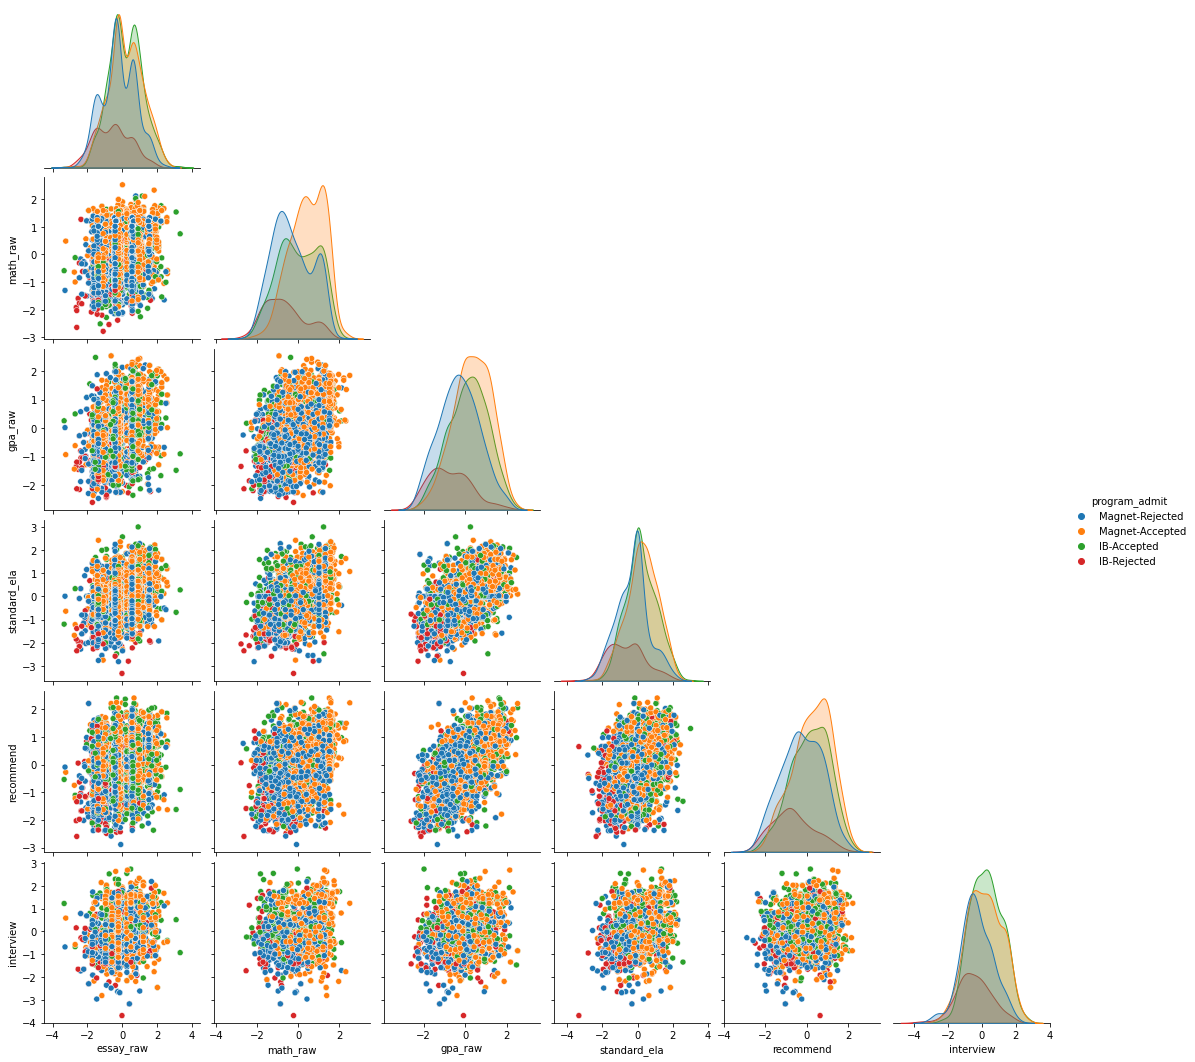

In [19]:
'''Create pariplots to show relationships between variables'''
sns.pairplot(df[plot_list], kind = 'scatter', hue = 'program_admit', corner = True)

<AxesSubplot:>

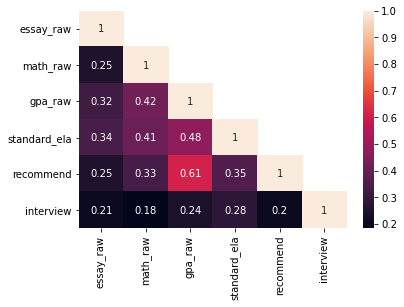

In [20]:
'''Correlation Heatmap for both programs'''
df_corr = df[plot_list].corr()
matrix = pd.DataFrame(np.tril(df_corr), columns = df_corr.columns).replace(0, np.nan)
matrix.set_index(df_corr.columns, drop = True, inplace = True)
sns.heatmap(matrix, annot=True)

In [21]:
'''Function to perform PCA analysis'''

'''Split data into test and train IB'''
def conduct_pca(df, pca_list, n_components):
    X = df[pca_list].drop(pca_list[0], axis = 1)
    y = df[pca_list[0]].astype('int32')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, stratify = y, random_state=42)
    
    '''Create PCA model'''
    pca = PCA(n_components = n_components)
    pca.fit(X_train, y_train)
    
    '''Find cumulative variance of components'''
    cum_variance = np.cumsum(pca.explained_variance_ratio_*100)
    variance = pca.explained_variance_ratio_*100

    '''Print explained variance with all factors'''
    print(f'Cumulative variance explained by model {cum_variance}')
    print(f'The explained variance for each factor is: {variance}')
    
    '''Create Scree Plot'''
    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.xticks(np.arange(1,6,1));

    return pca, X, y, X_train, X_test, y_train, y_test

In [22]:
'''Function to draw PCA biplot retreived from: 
https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot'''

def myplot(score, coeff, y, labels = None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    plt.scatter(xs * scalex, ys * scaley, c=y)

    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

### IB PCA Analysis - With Interview

<AxesSubplot:>

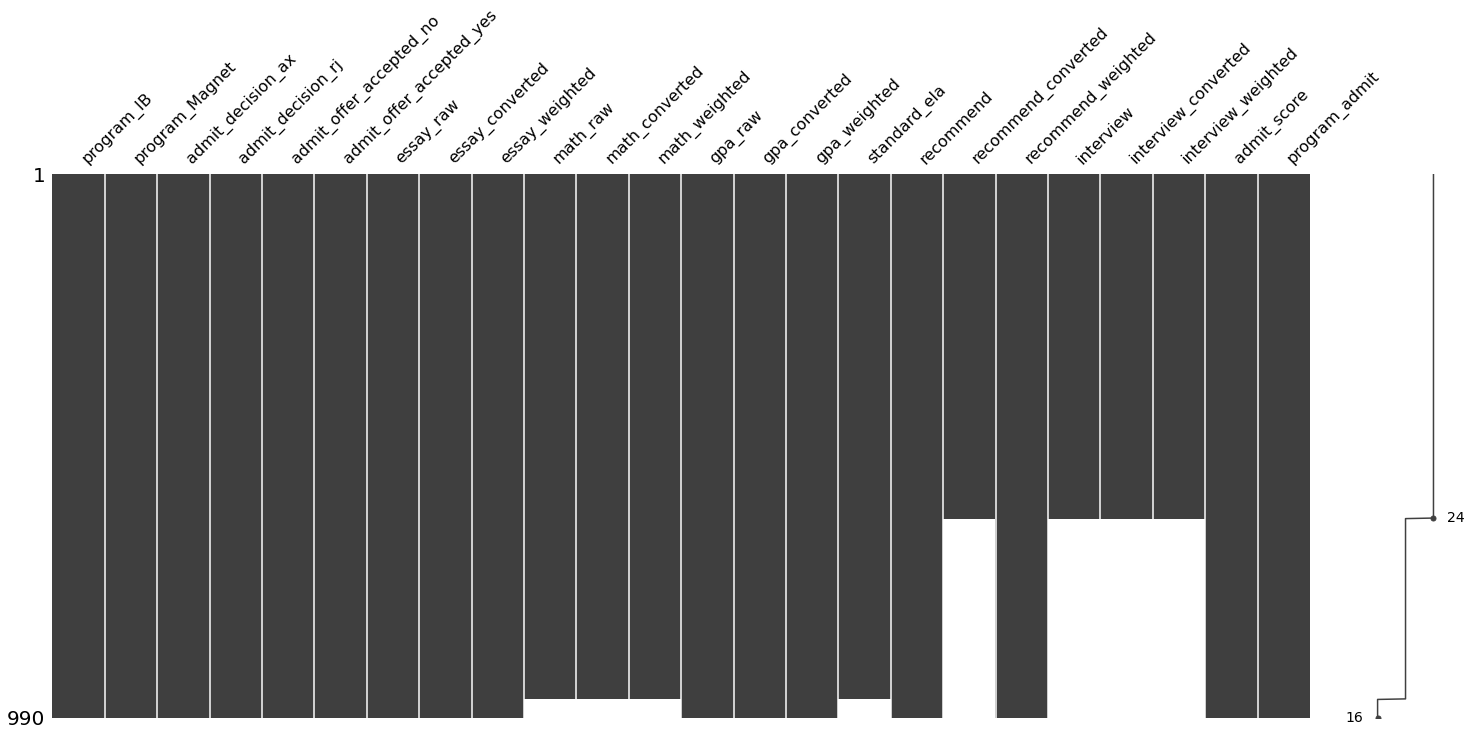

In [23]:
msno.matrix(ib_df)

In [24]:
ib_df_interview = ib_df.dropna(how = 'any')

<AxesSubplot:>

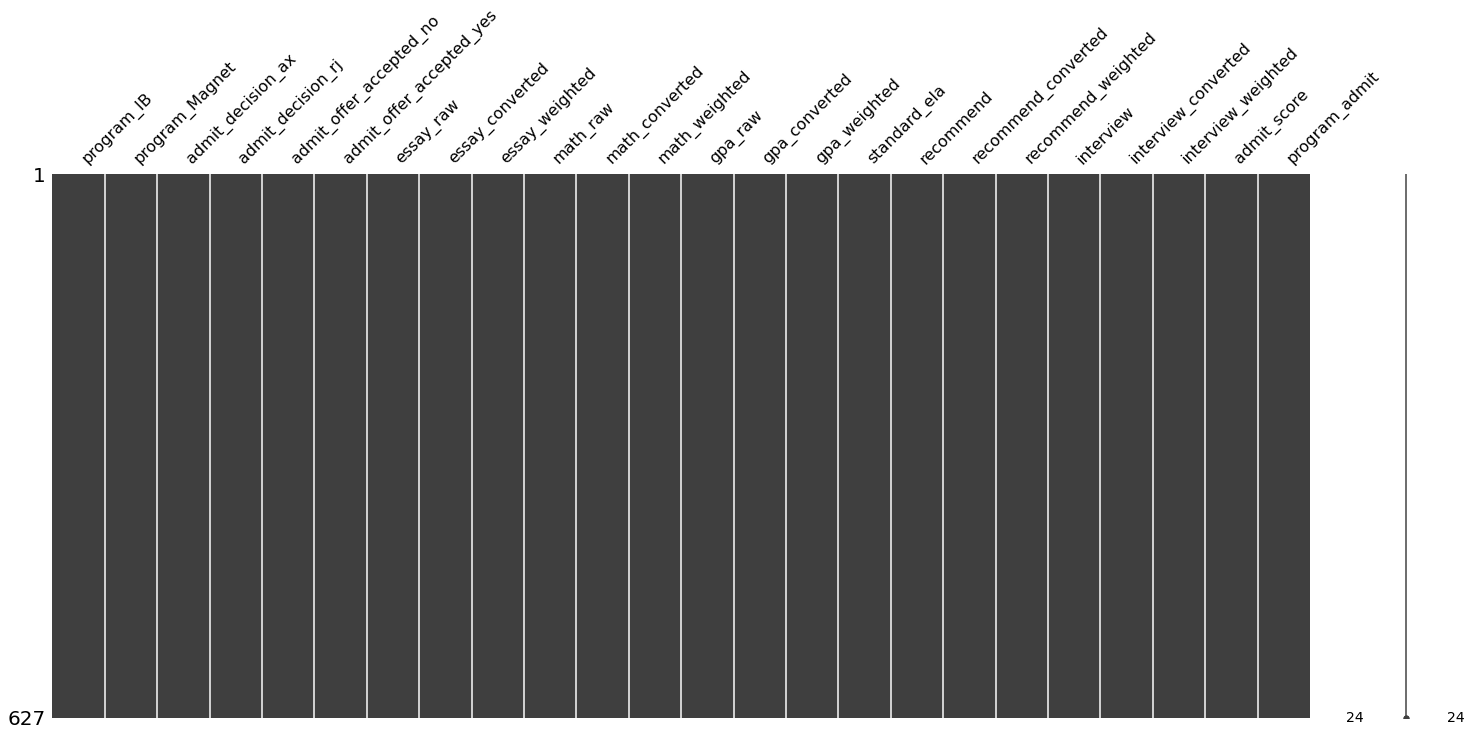

In [25]:
msno.matrix(ib_df_interview)

In [109]:
ib_df_interview.head()

program_IB  program_Magnet  admit_decision_ax  admit_decision_rj  \
18      1.0000          0.0000             1.0000             0.0000   
19      1.0000          0.0000             1.0000             0.0000   
20      1.0000          0.0000             1.0000             0.0000   
21      1.0000          0.0000             1.0000             0.0000   
22      1.0000          0.0000             1.0000             0.0000   

    admit_offer_accepted_no  admit_offer_accepted_yes  essay_raw  \
18                   0.0000                    1.0000    -0.9139   
19                   0.0000                    1.0000     0.7712   
20                   0.0000                    1.0000    -3.3395   
21                   0.0000                    1.0000    -0.9139   
22                   0.0000                    1.0000     0.7712   

    essay_converted  essay_weighted  math_raw  ...  gpa_weighted  \
18          -0.5014          0.1563   -0.5874  ...       -1.2891   
19           0.4153          0.8473   -0.5874  ...       -0.4097   
20          -1.9957         -1.0138   -0.5874  ...       -0.4097   
21          -0.5014          0.1563    0.5742  ...       -0.4097   
22           0.4153          0.8473   -0.0075  ...       -0.8657   

    standard_ela  recommend  recommend_converted  recommend_weighted  \
18       -1.3882     0.0977               0.1813              0.6030   
19        0.1810    -0.1670              -0.0499              0.4165   
20       -1.1940    -0.5348              -0.3759              0.1313   
21       -0.0054    -0.8694              -0.6778             -0.1050   
22        0.4126     0.3786               0.4239              0.7961   

    interview  interview_converted  interview_weighted  admit_score  \
18     0.1812               0.2814              0.5857      -0.7110   
19    -0.3427               0.2814              0.5857      -0.2884   
20     1.2248               0.9276              1.0244      -0.1848   
21    -0.6930               0.2814              0.5857       0.0261   
22     0.6167               0.6028              0.8075       0.4333   

    program_admit  
18    IB-Accepted  
19    IB-Accepted  
20    IB-Accepted  
21    IB-Accepted  
22    IB-Accepted  

[5 rows x 24 columns]

<AxesSubplot:>

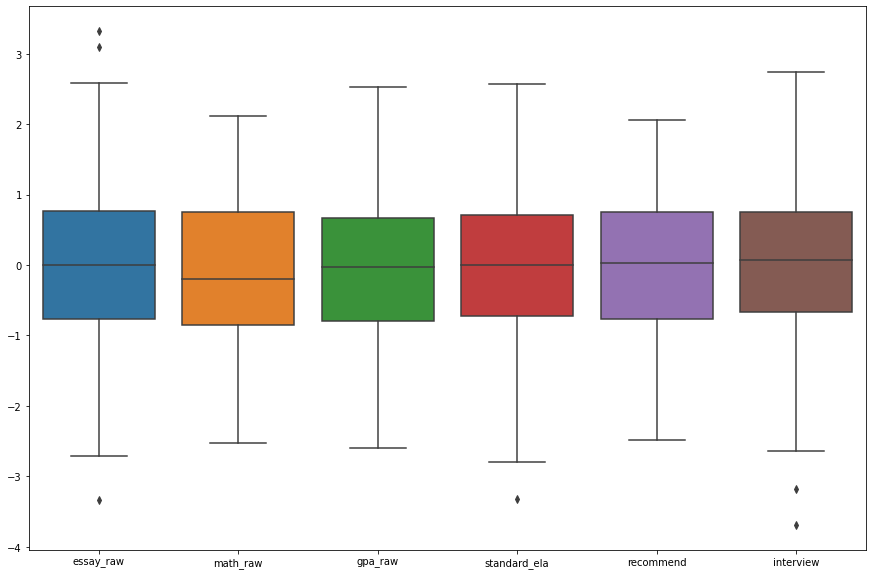

In [26]:
plot_list = ['essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']

fig, ax = plt.subplots(figsize= (15, 10))
sns.boxplot(data = ib_df_interview[plot_list])

In [27]:
'''Statistical test for skew'''
for column in ib_df_interview[plot_list]:
    print(column, skewtest(ib_df_interview[column], nan_policy = 'propagate'))

essay_raw SkewtestResult(statistic=-0.05051958089238174, pvalue=0.9597083460312207)
math_raw SkewtestResult(statistic=0.3228405722823104, pvalue=0.7468159846063096)
gpa_raw SkewtestResult(statistic=-1.0143129725744935, pvalue=0.31043343589663774)
standard_ela SkewtestResult(statistic=0.06784925861275817, pvalue=0.9459056313732597)
recommend SkewtestResult(statistic=-1.8228948978093011, pvalue=0.06831931084252771)
interview SkewtestResult(statistic=-0.6498707010281678, pvalue=0.5157757451093564)


Cumulative variance explained by model [ 44.53167643  60.70043644  74.44937125  86.20523713  94.92961219
 100.        ]
The explained variance for each factor is: [44.53167643 16.16876    13.74893482 11.75586588  8.72437505  5.07038781]


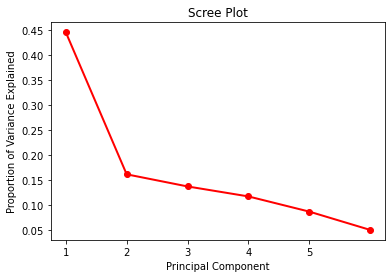

In [28]:
'''Conduct PCA on IB data with 6 components'''
pca_list = ['program_IB','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']
pca, X, y, X_train, X_test, y_train, y_test = conduct_pca(ib_df_interview, pca_list, 6)

Cumulative variance explained by model [44.53167643 60.70043644]
The explained variance for each factor is: [44.53167643 16.16876   ]


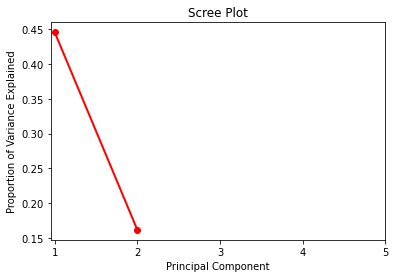

In [99]:
'''Conduct PCA on IB data with 2 components'''
pca_list = ['program_IB','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']
pca, X, y, X_train, X_test, y_train, y_test = conduct_pca(ib_df_interview, pca_list, 2)

In [100]:
'''Calculate pc loadings - IB'''
pd.options.display.float_format = '{:,.4f}'.format
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=X_train.columns)
loadings

PC1     PC2
essay_raw    -0.3438 -0.3770
math_raw     -0.4014  0.2366
gpa_raw      -0.4927  0.3157
standard_ela -0.4710 -0.0216
recommend    -0.4342  0.2278
interview    -0.2600 -0.8061

In [115]:
'''Transform IB Data'''
pca_trans = pca.transform(X_test)
pca_trans_df = pd.DataFrame(pca_trans, columns = ['PC1', 'PC2'])

ib_interview_pca_df = pd.DataFrame(pca.transform(X), columns = ['PC1', 'PC2'])
ib_interview_pca_df['program_admit'] = ib_df_interview['program_admit'].values

In [117]:
ib_interview_pca_df.head()

'''Pickle datafile'''
with open('ib_interview_pca.pkl', 'wb') as f:
    pickle.dump(ib_interview_pca_df, f)

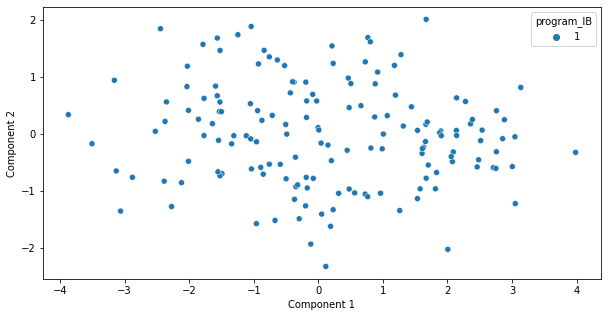

In [32]:
'''Plot Primary Components'''
plt.figure(figsize=(10,5))
sns.scatterplot(x = pca_trans[:,0], y = pca_trans[:,1], hue = y_test)
plt.xlabel('Component 1')
plt.ylabel('Component 2');

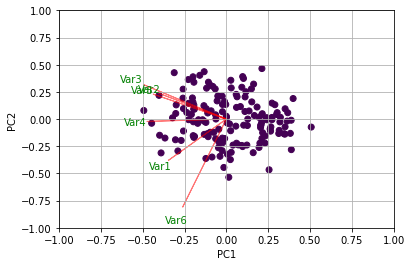

In [33]:
'''Create biplot for IB PCA'''
myplot(pca_trans[:,0:3],np.transpose(pca.components_[0:3, :]), y_test)

### Magnet PCA Analysis - With Interview

In [120]:
magnet_df_interview = magnet_df.dropna(how = 'any')

<AxesSubplot:>

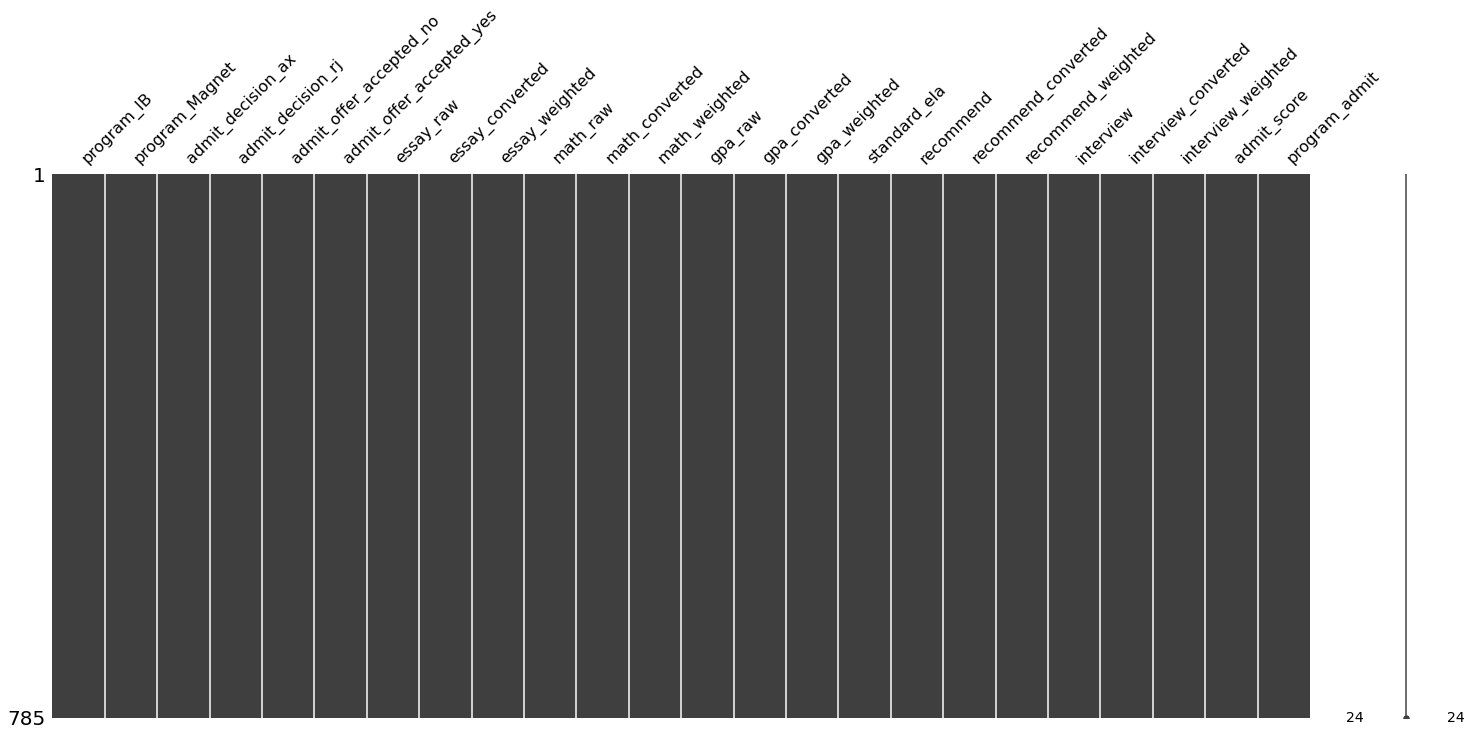

In [121]:
msno.matrix(magnet_df_interview)

<AxesSubplot:>

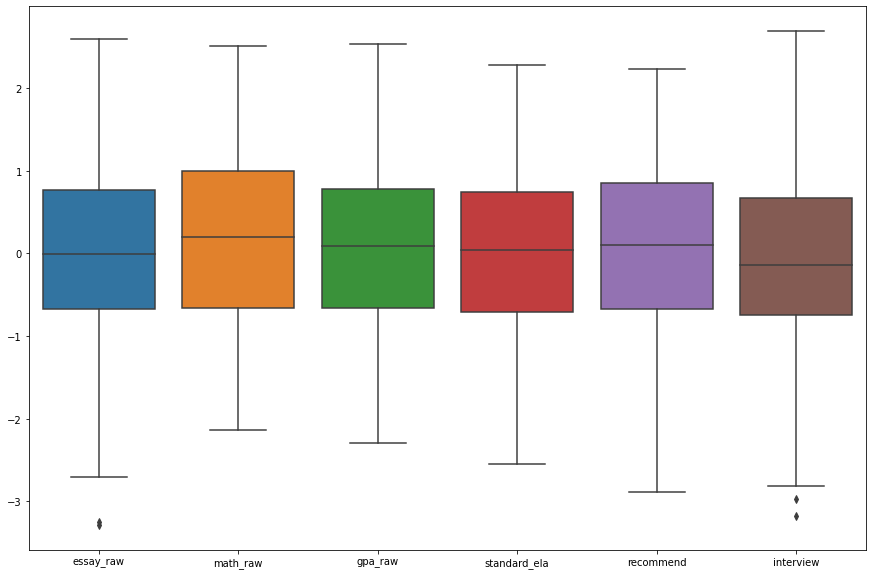

In [122]:
plot_list = ['essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']

fig, ax = plt.subplots(figsize= (15, 10))
sns.boxplot(data = magnet_df_interview[plot_list])

In [123]:
for column in magnet_df_interview[plot_list]:
    print(column, skewtest(magnet_df_interview[column], nan_policy = 'propagate'))

essay_raw SkewtestResult(statistic=-0.38354308754311756, pvalue=0.7013171290036001)
math_raw SkewtestResult(statistic=-2.1830686951732727, pvalue=0.029030751523639833)
gpa_raw SkewtestResult(statistic=-1.280819200287067, pvalue=0.20025717840943935)
standard_ela SkewtestResult(statistic=-1.1541006986105486, pvalue=0.24845888701016638)
recommend SkewtestResult(statistic=-3.1285617736700777, pvalue=0.0017566408176971915)
interview SkewtestResult(statistic=0.22132925894180872, pvalue=0.8248360695075704)


Cumulative variance explained by model [ 45.00611305  60.39177544  74.19580051  85.69932547  94.62813358
 100.        ]
The explained variance for each factor is: [45.00611305 15.38566239 13.80402507 11.50352495  8.92880811  5.37186642]


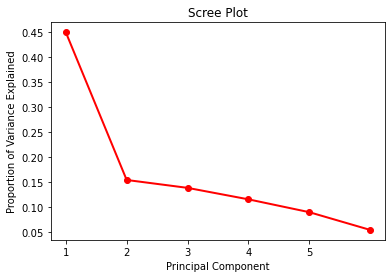

In [124]:
'''Conduct PCA on Magnet data with 6 components'''
pca_list = ['program_Magnet','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']
pca, X, y, X_train, X_test, y_train, y_test = conduct_pca(magnet_df_interview, pca_list, 6)

Cumulative variance explained by model [45.00611305 60.39177544]
The explained variance for each factor is: [45.00611305 15.38566239]


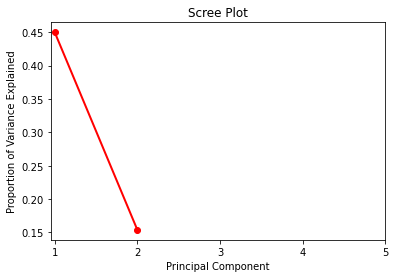

In [125]:
'''Conduct PCA on Magnet data with 2 components'''
pca_list = ['program_Magnet','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']
pca, X, y, X_train, X_test, y_train, y_test = conduct_pca(magnet_df_interview, pca_list, 2)

In [126]:
'''Calculate pc loadings - Magnet'''
pd.options.display.float_format = '{:,.4f}'.format
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=X_train.columns)
loadings

PC1     PC2
essay_raw    -0.3015  0.6191
math_raw     -0.3903 -0.1755
gpa_raw      -0.5026 -0.2277
standard_ela -0.4398  0.2881
recommend    -0.4583 -0.5508
interview    -0.3175  0.3843

In [127]:
'''Transform Magnet Data'''
pca_trans = pca.transform(X_test)
pca_trans_df = pd.DataFrame(pca_trans, columns = ['PC1', 'PC2'])

magnet_interview_pca_df = pd.DataFrame(pca.transform(X), columns = ['PC1', 'PC2'])
magnet_interview_pca_df['program_admit'] = magnet_df_interview['program_admit'].values

In [128]:
'''Pickle datafile'''
with open('magnet_interview_pca.pkl', 'wb') as f:
    pickle.dump(magnet_interview_pca_df, f)

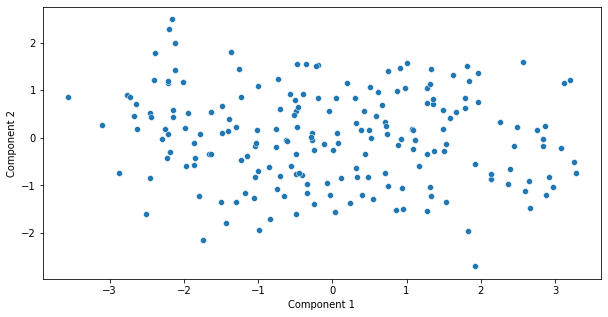

In [42]:
'''Plot Primary Components'''
plt.figure(figsize=(10,5))
sns.scatterplot(x = pca_trans[:,0], y = pca_trans[:,1])
plt.xlabel('Component 1')
plt.ylabel('Component 2');

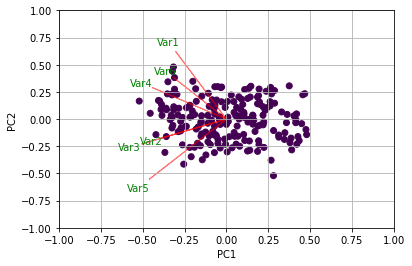

In [43]:
'''Create biplot for Magnet PCA'''
myplot(pca_trans[:,0:2],np.transpose(pca.components_[0:2, :]), y_test)

### IB Analysis - Without Interview

<AxesSubplot:>

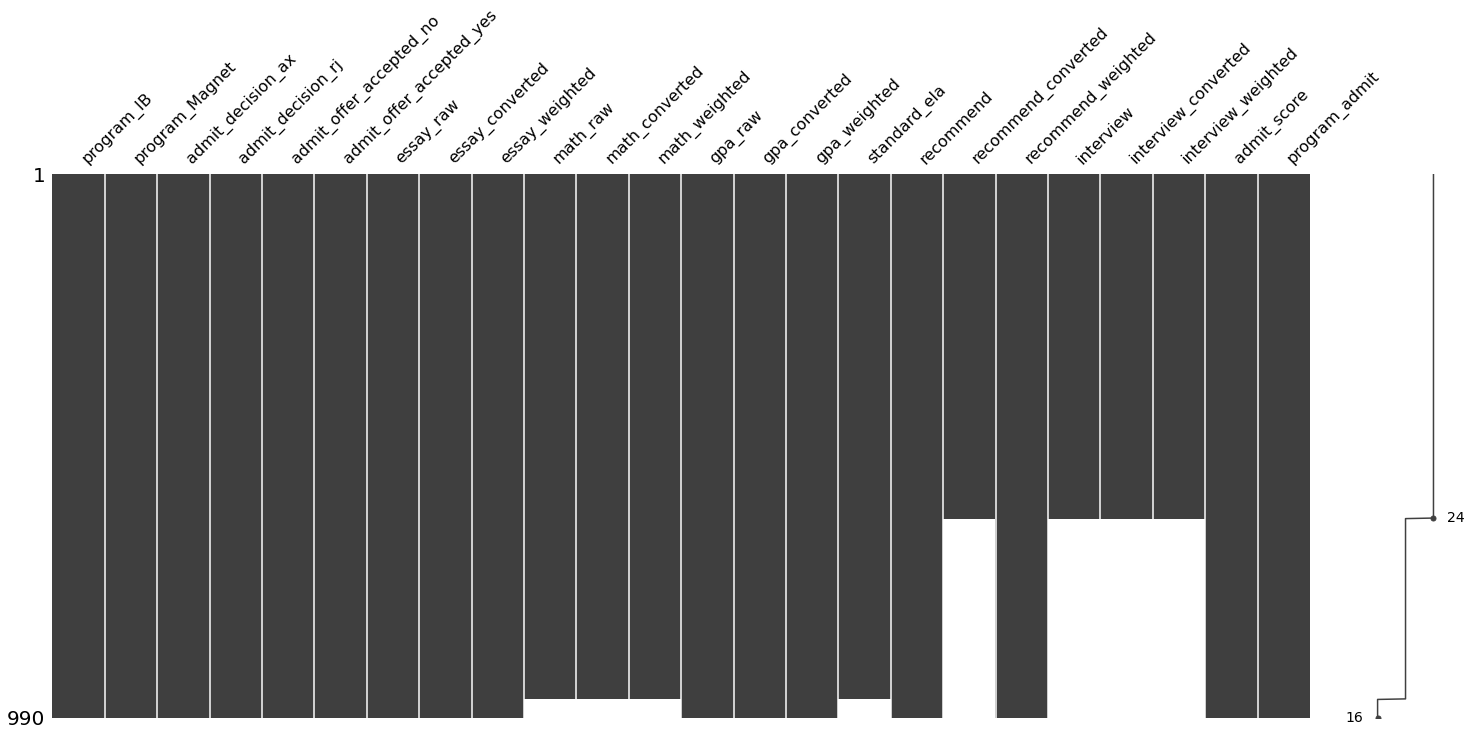

In [135]:
msno.matrix(ib_df)

In [136]:
drop_list = ['recommend_converted', 'interview', 'interview_converted', 'interview_weighted']
ib_no_interview = ib_df.drop(drop_list, axis = 1)

<AxesSubplot:>

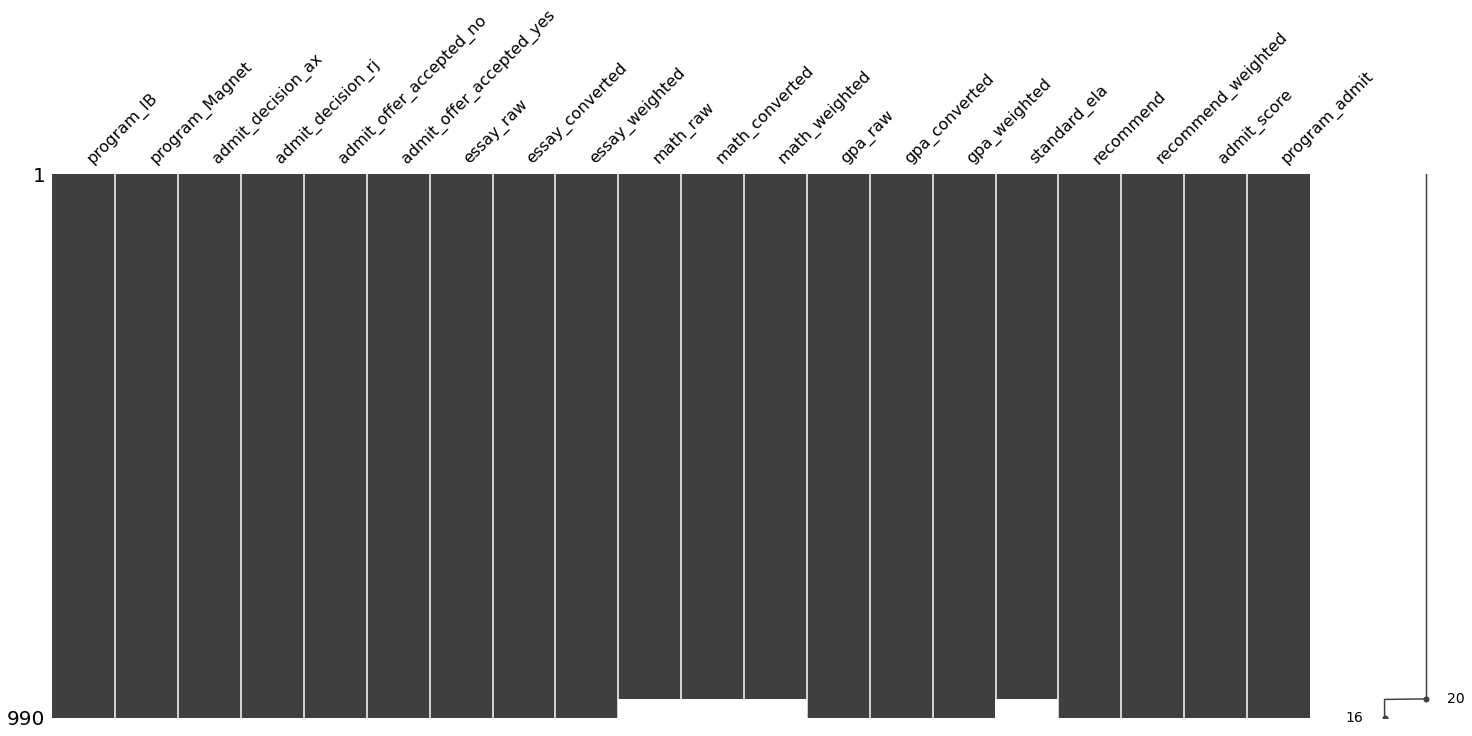

In [137]:
msno.matrix(ib_no_interview)

In [138]:
ib_no_interview['standard_ela'].fillna(ib_no_interview['standard_ela'].mean(), inplace = True)
ib_no_interview['math_raw'].fillna(ib_no_interview['math_raw'].mean(), inplace = True)

<AxesSubplot:>

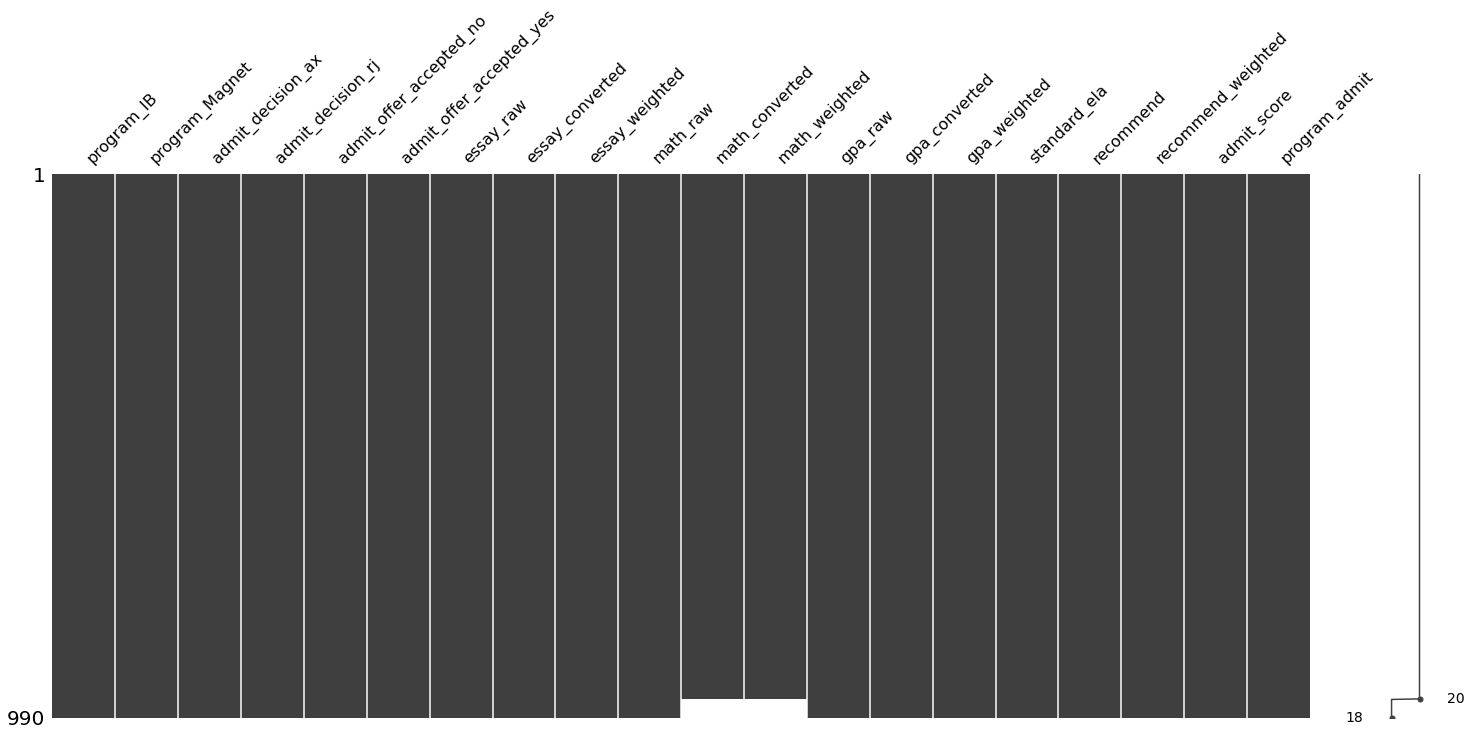

In [139]:
msno.matrix(ib_no_interview)

<AxesSubplot:>

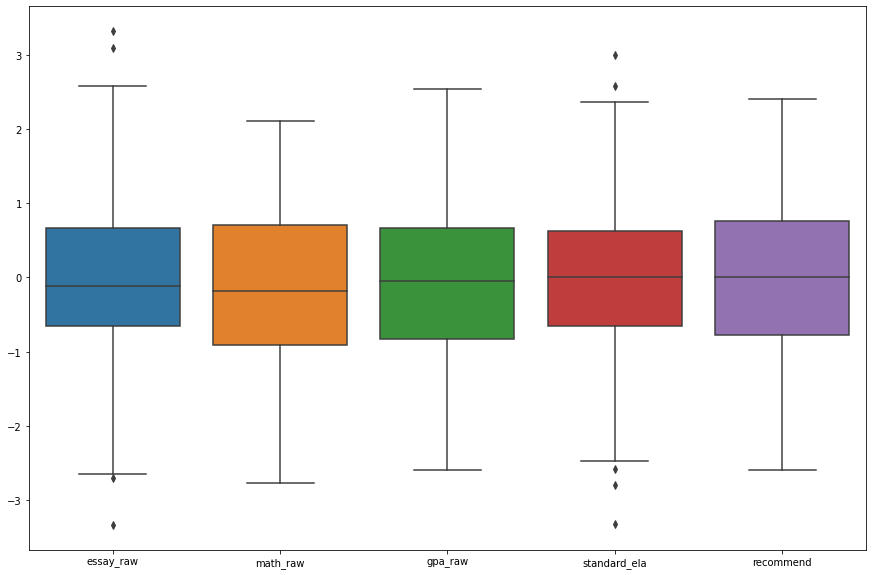

In [140]:
plot_list = ['essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend']

fig, ax = plt.subplots(figsize= (15, 10))
sns.boxplot(data = ib_no_interview[plot_list])

In [141]:
for column in ib_no_interview[plot_list]:
    print(column, skewtest(ib_no_interview[column], nan_policy = 'propagate'))

essay_raw SkewtestResult(statistic=-0.19784917960328086, pvalue=0.8431630668756332)
math_raw SkewtestResult(statistic=0.08537524557621524, pvalue=0.931963072464361)
gpa_raw SkewtestResult(statistic=-0.9700994000134998, pvalue=0.3319969480516072)
standard_ela SkewtestResult(statistic=-0.49228052528614563, pvalue=0.6225210454335578)
recommend SkewtestResult(statistic=-2.22418096691688, pvalue=0.026136271082164698)


Cumulative variance explained by model [ 51.48204553  68.92374167  83.06664529  93.35388629 100.        ]
The explained variance for each factor is: [51.48204553 17.44169615 14.14290362 10.287241    6.64611371]


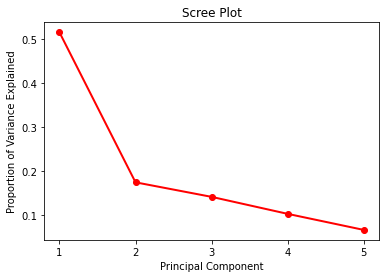

In [142]:
'''Conduct PCA on IB data with 6 components'''
pca_list = ['program_IB','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend']
pca, X, y, X_train, X_test, y_train, y_test = conduct_pca(ib_no_interview, pca_list, 5)

Cumulative variance explained by model [51.48204553 68.92374167]
The explained variance for each factor is: [51.48204553 17.44169615]


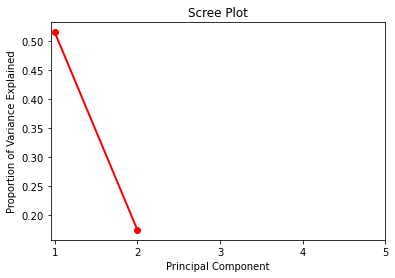

In [143]:
'''Conduct PCA on IB data with 2 components'''
pca_list = ['program_IB','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend']
pca, X, y, X_train, X_test, y_train, y_test = conduct_pca(ib_no_interview, pca_list, 2)

In [144]:
'''Calculate pc loadings - IB'''
pd.options.display.float_format = '{:,.4f}'.format
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=X_train.columns)
loadings

PC1     PC2
essay_raw    -0.3561  0.7786
math_raw     -0.4236  0.0727
gpa_raw      -0.5260 -0.3630
standard_ela -0.4495  0.2134
recommend    -0.4637 -0.4595

In [145]:
'''Transform IB Data'''
pca_trans = pca.transform(X_test)
pca_trans_df = pd.DataFrame(pca_trans, columns = ['PC1', 'PC2'])

ib_no_interview_pca_df = pd.DataFrame(pca.transform(X), columns = ['PC1', 'PC2'])
ib_no_interview_pca_df['program_admit'] = ib_no_interview['program_admit'].values

In [146]:
'''Pickle datafile'''
with open('ib_no_interview_pca.pkl', 'wb') as f:
    pickle.dump(ib_no_interview_pca_df, f)

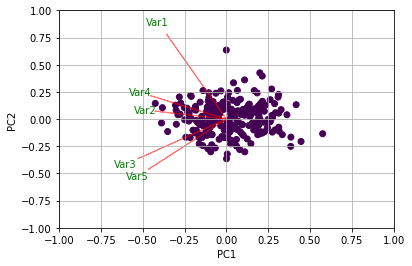

In [58]:
'''Create biplot for IB PCA'''
myplot(pca_trans[:,0:2],np.transpose(pca.components_[0:2, :]), y_test)

### Magnet Analysis - without interview

In [147]:
magnet_df

program_IB  program_Magnet  admit_decision_ax  admit_decision_rj  \
0         0.0000          1.0000             0.0000             1.0000   
1         0.0000          1.0000             0.0000             1.0000   
2         0.0000          1.0000             0.0000             0.0000   
3         0.0000          1.0000             1.0000             0.0000   
4         0.0000          1.0000             1.0000             0.0000   
...          ...             ...                ...                ...   
2624      0.0000          1.0000             0.0000             1.0000   
2625      0.0000          1.0000             0.0000             1.0000   
2626      0.0000          1.0000             0.0000             1.0000   
2627      0.0000          1.0000             0.0000             1.0000   
2628      0.0000          1.0000             0.0000             1.0000   

      admit_offer_accepted_no  admit_offer_accepted_yes  essay_raw  \
0                      1.0000                    0.0000    -0.0024   
1                      1.0000                    0.0000     0.7712   
2                      1.0000                    0.0000     0.7712   
3                      0.0000                    1.0000     0.7712   
4                      0.0000                    1.0000    -0.9139   
...                       ...                       ...        ...   
2624                   1.0000                    0.0000     0.0100   
2625                   1.0000                    0.0000     0.0100   
2626                   1.0000                    0.0000     0.0100   
2627                   1.0000                    0.0000     0.0100   
2628                   1.0000                    0.0000     0.0100   

      essay_converted  essay_weighted  math_raw  ...  gpa_weighted  \
0             -0.0571         -1.2611   -0.5874  ...        0.9535   
1              0.4153         -1.1149   -1.5187  ...       -0.4097   
2              0.4153         -1.1149    2.1119  ...        2.5128   
3              0.4153         -1.1149    1.9738  ...        2.5128   
4             -0.5014         -1.4006    1.1387  ...        1.7098   
...               ...             ...       ...  ...           ...   
2624              nan             nan    0.6362  ...        1.4465   
2625              nan             nan   -0.6335  ...       -0.4986   
2626              nan             nan   -1.1023  ...       -0.4986   
2627              nan             nan   -1.8743  ...       -1.8605   
2628              nan             nan   -1.7976  ...       -1.8605   

      standard_ela  recommend  recommend_converted  recommend_weighted  \
0          -0.4758    -1.0750              -0.8661             -1.3229   
1           0.1810    -0.8694              -0.6778             -1.2303   
2          -0.3812     1.4983               1.3678             -0.2979   
3           0.5048     1.3247               1.2236             -0.3603   
4           0.5048     0.5253               0.5497             -0.6577   
...            ...        ...                  ...                 ...   
2624        0.0166     0.4794                  nan              0.2203   
2625        0.0166     0.0189                  nan              0.0167   
2626        0.0166    -0.5905                  nan             -0.3319   
2627        0.0166    -0.9450                  nan             -0.6127   
2628        0.0166    -1.8338                  nan             -1.9695   

      interview  interview_converted  interview_weighted  admit_score  \
0       -0.7807              -2.0660             -1.5769      -1.5924   
1       -0.5615              -2.0660             -1.5769      -1.6328   
2       -1.7146              -2.0660             -1.5769       1.3073   
3       -2.1943              -0.6586             -1.2821       1.8491   
4       -0.6053               0.2814             -1.1270       0.4990   
...         ...                  ...                 ...          ...   
2624        nan                  na

<AxesSubplot:>

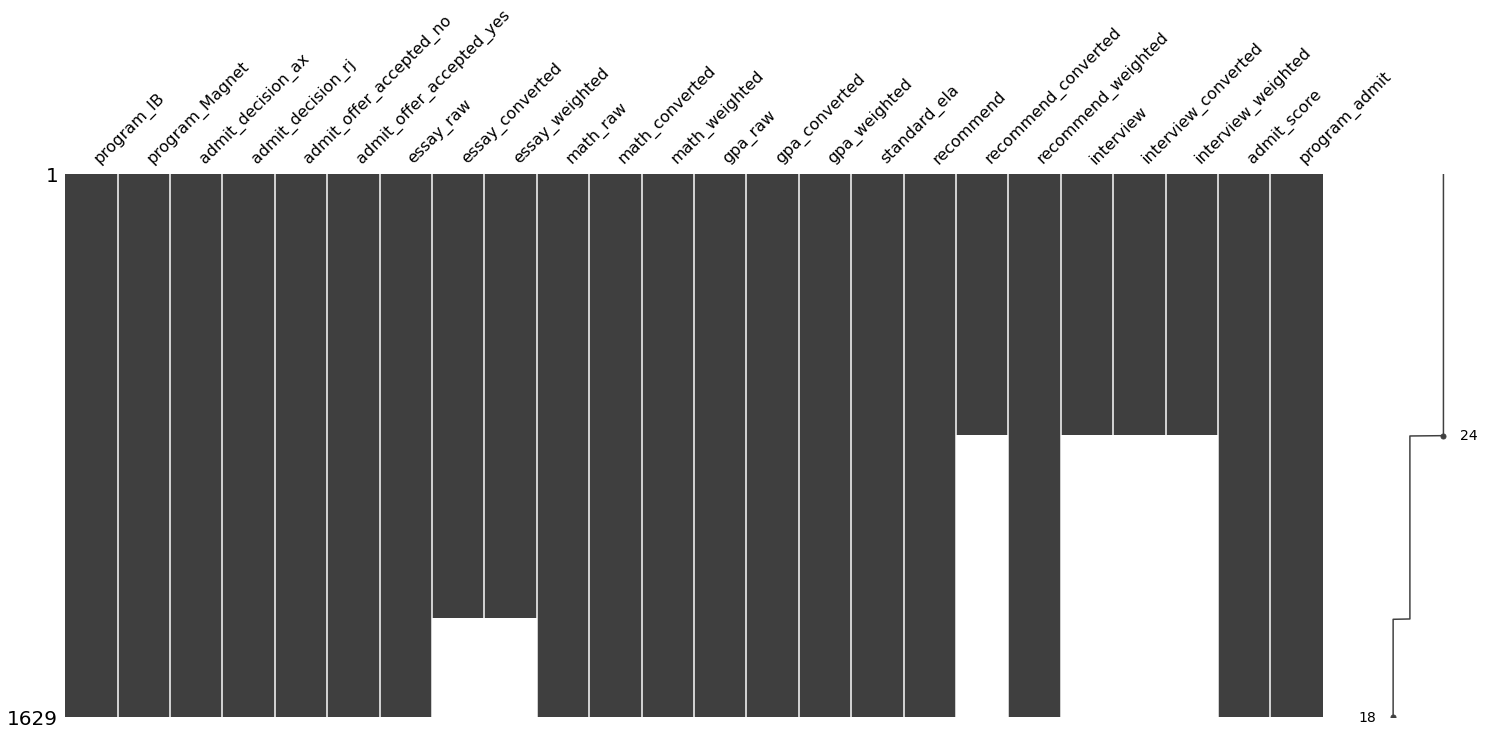

In [148]:
msno.matrix(magnet_df)

In [149]:
magnet_df['essay_raw'].fillna(magnet_df['essay_raw'].mean(), inplace = True)
magnet_df['standard_ela'].fillna(magnet_df['standard_ela'].mean(), inplace = True)
drop_list = ['recommend_converted', 'interview', 'interview_converted', 'interview_weighted',\
            'essay_converted', 'essay_weighted']
magnet_no_interview = magnet_df.drop(drop_list, axis = 1)

C:\Users\scott\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


<AxesSubplot:>

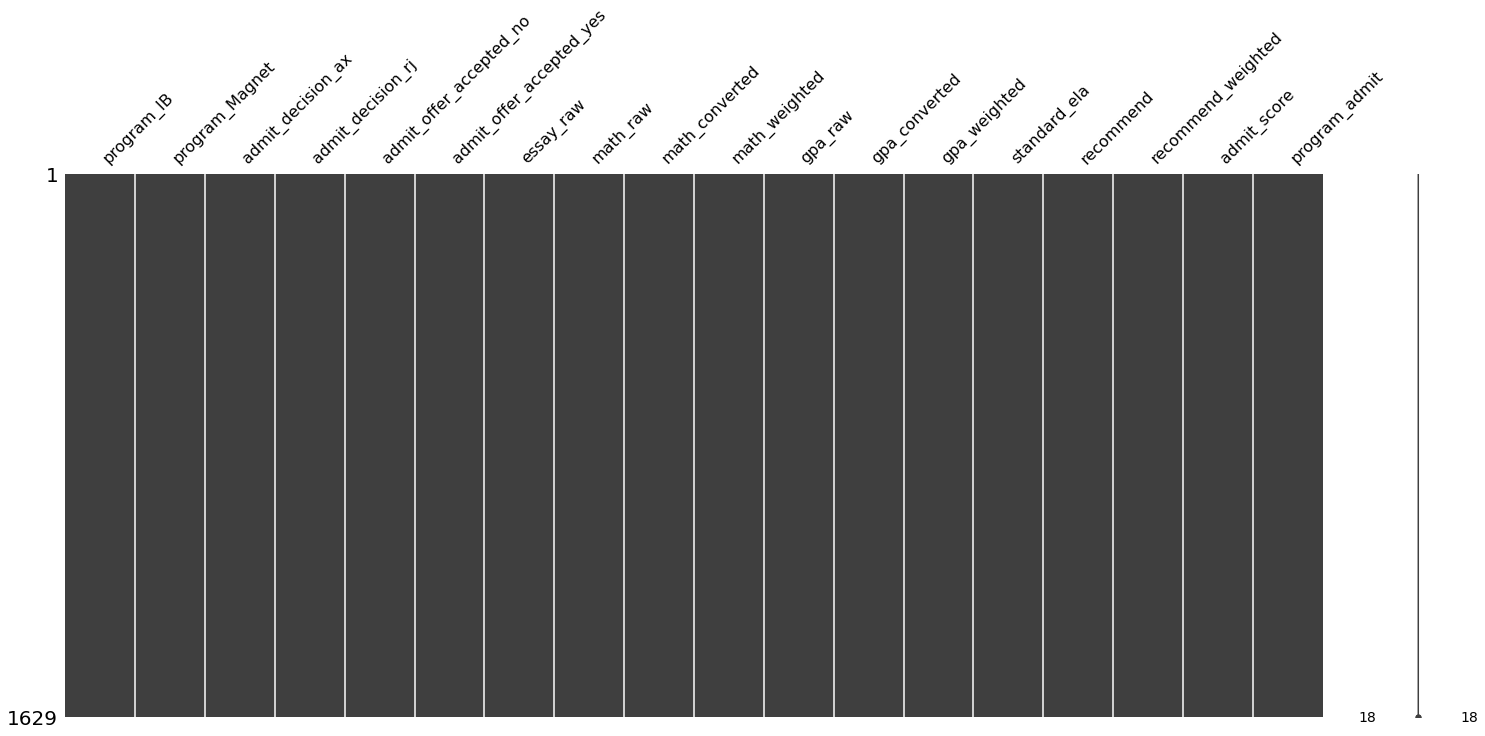

In [150]:
msno.matrix(magnet_no_interview)

Cumulative variance explained by model [ 48.83919138  65.30442273  81.06753779  91.8834796  100.        ]
The explained variance for each factor is: [48.83919138 16.46523135 15.76311506 10.81594182  8.1165204 ]


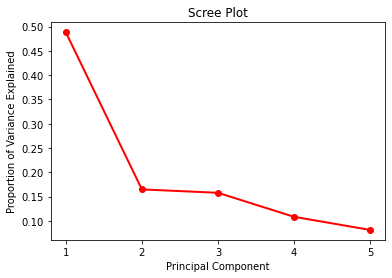

In [151]:
'''Conduct PCA on Magnet data with 5 components'''
pca_list = ['program_Magnet', 'math_raw', 'gpa_raw', 'recommend', 'essay_raw', 'standard_ela']
pca, X, y, X_train, X_test, y_train, y_test = conduct_pca(magnet_no_interview, pca_list, 5)

Cumulative variance explained by model [48.83919138 65.30442273]
The explained variance for each factor is: [48.83919138 16.46523135]


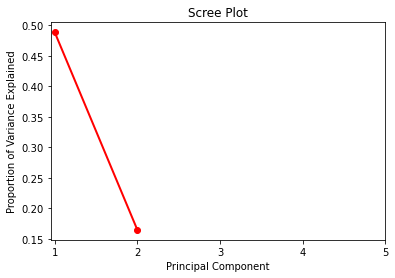

In [152]:
'''Conduct PCA on Magnet data with 2 components'''
pca_list = ['program_Magnet', 'math_raw', 'gpa_raw', 'recommend', 'essay_raw', 'standard_ela']
pca, X, y, X_train, X_test, y_train, y_test = conduct_pca(magnet_no_interview, pca_list, 2)

In [153]:
'''Calculate pc loadings - Magnet'''
pd.options.display.float_format = '{:,.4f}'.format
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=X_train.columns)
loadings

PC1     PC2
math_raw     -0.4409  0.0552
gpa_raw      -0.5631 -0.2149
recommend    -0.5100 -0.5129
essay_raw    -0.3045  0.7511
standard_ela -0.3685  0.3515

In [154]:
'''Transform Magnet Data'''
pca_trans = pca.transform(X_test)
pca_trans_df = pd.DataFrame(pca_trans, columns = ['PC1', 'PC2'])

magnet_no_interview_pca_df = pd.DataFrame(pca.transform(X), columns = ['PC1', 'PC2'])
magnet_no_interview_pca_df['program_admit'] = magnet_no_interview['program_admit'].values

In [155]:
'''Pickle datafile'''
with open('magnet_no_interview_pca.pkl', 'wb') as f:
    pickle.dump(magnet_no_interview_pca_df, f)

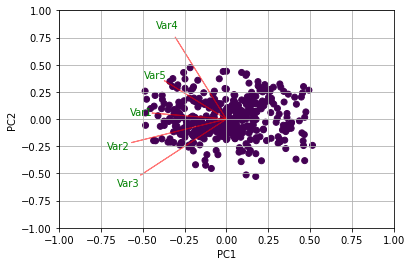

In [156]:
'''Create biplot for Magnet PCA'''
myplot(pca_trans[:,0:2],np.transpose(pca.components_[0:2, :]), y_test)